In [1]:
from os.path import join, expanduser
DATA_ROOT = join(expanduser("~"), "ACCENT_CONVERSION_DATASET")
DATA_SOURCE = join(expanduser("~"), "ACCENT_CONVERSION_DATASET/ksp/wav")
DATA_TARGET = join(expanduser("~"), "ACCENT_CONVERSION_DATASET/bdl/wav")
!ls $DATA_ROOT

awb  bdl  ksp


In [2]:
%pylab inline
rcParams["figure.figsize"] = (16,5)

from nnmnkwii.datasets import PaddedFileSourceDataset
from nnmnkwii.datasets.cmu_arctic import CMUArcticWavFileDataSource
from nnmnkwii.preprocessing.alignment import DTWAligner
from nnmnkwii.preprocessing import trim_zeros_frames, remove_zeros_frames, delta_features
from nnmnkwii.util import apply_each2d_trim
from nnmnkwii.metrics import melcd
from nnmnkwii.baseline.gmm import MLPG

from os.path import basename, splitext
import sys
import time

import numpy as np
from scipy.io import wavfile
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
import pyworld
import pysptk
from pysptk.synthesis import MLSADF, Synthesizer
import librosa
import librosa.display
import IPython
from IPython.display import Audio

Populating the interactive namespace from numpy and matplotlib


In [3]:
fs = 16000
fftlen = pyworld.get_cheaptrick_fft_size(fs)
alpha = pysptk.util.mcepalpha(fs)
order = 24
frame_period = 5
hop_length = int(fs * (frame_period * 0.001))
max_files = 100 # number of utterances to be used.
test_size = 0.03
use_delta = True

if use_delta:
    windows = [
        (0, 0, np.array([1.0])),
        (1, 1, np.array([-0.5, 0.0, 0.5])),
        (1, 1, np.array([1.0, -2.0, 1.0])),
    ]
else:
    windows = [
        (0, 0, np.array([1.0])),
    ]

In [4]:
def collect_files(paths):
    paths_train, paths_test = train_test_split(
        paths, test_size=test_size, random_state=1234)

        # keep paths for later testing
    test_paths = paths_test
    return paths_train

def collect_features(path):
    fs, x = wavfile.read(path)
    x = x.astype(np.float64)
    f0, timeaxis = pyworld.dio(x, fs, frame_period=frame_period)
    f0 = pyworld.stonemask(x, f0, timeaxis, fs)
    spectrogram = pyworld.cheaptrick(x, f0, timeaxis, fs)
    spectrogram = trim_zeros_frames(spectrogram)
    mc = pysptk.sp2mc(spectrogram, order=order, alpha=alpha)
    return mc

In [5]:
def create_path(DATA_SOURCE,DATA_TARGET):
    path_s = []
    path_t = []
    for i in range(100,594):
        path = DATA_SOURCE+'/arctic_a0'+str(i)+'.wav'
        path_s.append(path)
        path = DATA_TARGET + '/arctic_a0'+str(i)+'.wav'
        path_t.append(path)
#     for i in range(100,540):
#         path = DATA_SOURCE+'/arctic_b0'+str(i)+'.wav'
#         path_s.append(path)
#         path = DATA_TARGET + '/arctic_b0'+str(i)+'.wav'
#         path_t.append(path)
#     print(len(path_s),len(path_t))
    return path_s,path_t


In [6]:
def padding(x):
    if x.shape[0]<1200:
        delta = np.zeros((1200-x.shape[0],25))
        x = np.append(x,delta,axis=0)
    else :
        x = x[:1200,:]
    x = x.reshape(1,x.shape[0],x.shape[1])
    return x

In [7]:
def get_mfcc():
    path_source,path_target = create_path(DATA_SOURCE,DATA_TARGET)
    source = np.zeros((1,1200,25))
    target = np.zeros((1,1200,25))
    i = 0
    for path_s in path_source :
        mc_s = collect_features(path_s)
        mc_s = padding(mc_s)
        source = np.append(source,mc_s,axis=0)
        i += 1
        if i%20==0:
            print(i," iterations done")
    for path_t in path_target :
        mc_t = collect_features(path_t)
        mc_t = padding(mc_t)
        target = np.append(target,mc_t,axis=0)
    return source[1:,:,:],target[1:,:,:]

In [ ]:
bdl,ksp = get_mfcc()

In [8]:
import pickle
file_name = open('MFCCs/bdl','rb')
bdl = pickle.load(file_name)
file_name = open('MFCCs/ksp','rb')
ksp = pickle.load(file_name)

In [ ]:
import pickle 
file_name = open('MFCCs/bdl','wb')
pickle.dump(bdl,file_name)
file_name = open('MFCCs/ksp','wb')
pickle.dump(ksp,file_name)

In [ ]:
bdl[1][1][1]

In [9]:
bdl = bdl[:900]
ksp = ksp[:900]

In [10]:
print(bdl.shape)

(900, 1200, 25)


In [11]:
# Plotting util
def plot_parallel(x,y):
    figure(figsize=(16,7))
    subplot(2,1,1)
    librosa.display.specshow(trim_zeros_frames(x).T, sr=fs, hop_length=hop_length, x_axis="time")
    colorbar()
    subplot(2,1,2)
    librosa.display.specshow(trim_zeros_frames(y).T, sr=fs, hop_length=hop_length, x_axis="time")
    colorbar()

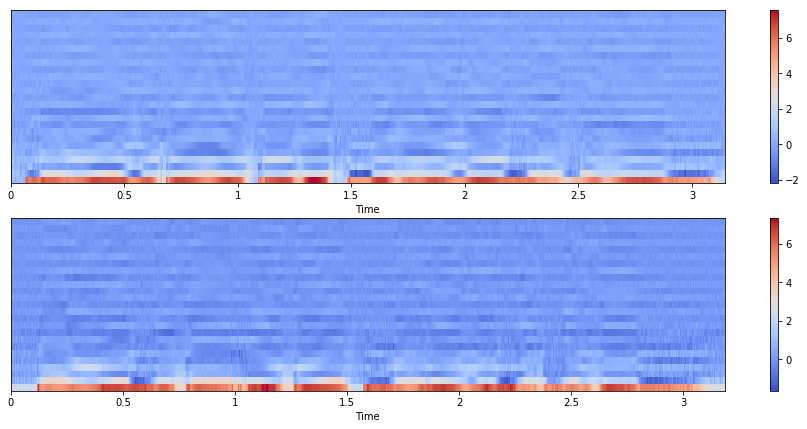

In [12]:
idx = 22 # any 
plot_parallel(bdl[idx],ksp[idx])

In [13]:
# Alignment
Y_aligned, X_aligned = DTWAligner(verbose=0, dist=melcd).transform((bdl, ksp))

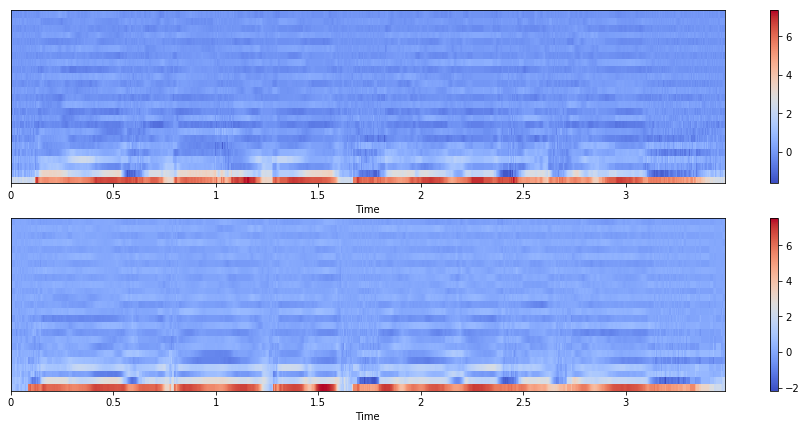

In [14]:
plot_parallel(X_aligned[idx],Y_aligned[idx])

In [15]:
# Drop 1st (power) dimension
X_aligned, Y_aligned = X_aligned[:, :, 1:], Y_aligned[:, :, 1:]

In [16]:
static_dim = X_aligned.shape[-1]
if use_delta:
    X_aligned = apply_each2d_trim(delta_features, X_aligned, windows)
    Y_aligned = apply_each2d_trim(delta_features, Y_aligned, windows)

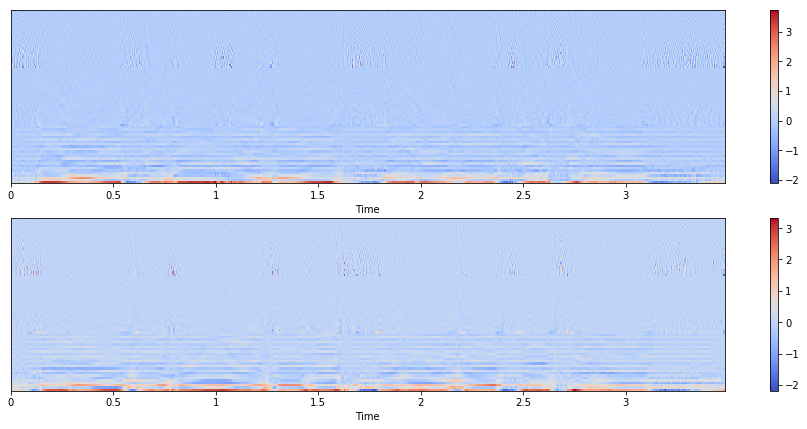

In [17]:
plot_parallel(X_aligned[idx],Y_aligned[idx])

In [18]:
XY = np.concatenate((X_aligned, Y_aligned), axis=-1).reshape(-1, Y_aligned.shape[-1]*2)
print(XY.shape)

(1130400, 144)


In [19]:
XY = remove_zeros_frames(XY)
print(XY.shape)

(598266, 144)


In [21]:
gmm = GaussianMixture(
    n_components=64, covariance_type="full", max_iter=100, verbose=1)

%time gmm.fit(XY)

Initialization 0


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/kushal/anaconda3/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1263, in time
    out = eval(code, glob, local_ns)
  File "<timed eval>", line 1, in <module>
  File "/home/kushal/anaconda3/lib/python3.6/site-packages/sklearn/mixture/base.py", line 194, in fit
    self.fit_predict(X, y)
  File "/home/kushal/anaconda3/lib/python3.6/site-packages/sklearn/mixture/base.py", line 245, in fit_predict
    self._m_step(X, log_resp)
  File "/home/kushal/anaconda3/lib/python3.6/site-packages/sklearn/mixture/gaussian_mixture.py", line 675, in _m_step
    self.covariance_type))
  File "/home/kushal/anaconda3/lib/python3.6/site-packages/sklearn/mixture/gaussian_mixture.py", line 285, in _estimate_gaussian_parameters
    }[covariance_type](resp, X, nk, means, reg_covar)
  File "/home/kushal/anaconda3/lib/python3.6/site-packages/sklearn/mixture/gaussian_mixture.py", line 167, in _estimate_gaussian_covariances_full
    covariances[k]

KeyboardInterrupt: 

In [ ]:
import pickle
file_name = open('saved_GMM_models/indian-american','wb')
pickle.dump(gmm,file_name)

In [ ]:
for k in range(3):
    plt.figure(figsize(10,10))
    plot(gmm.means_[k], linewidth=1.5, label="Mean of mixture {}".format(k+1))
legend(prop={"size": 16})

In [ ]:
imshow(gmm.covariances_[0], origin="bottom left")
colorbar()

In [ ]:
for k in range(3):
    plot(np.diag(gmm.covariances_[k]), linewidth=1.5, 
         label="Diagonal part of covariance matrix, mixture {}".format(k))
legend(prop={"size": 16})

In [ ]:
def test_one_utt(src_path, tgt_path, disable_mlpg=False, diffvc=True):
    # GMM-based parameter generation is provided by the library in `baseline` module
    if disable_mlpg:
        # Force disable MLPG
        paramgen = MLPG(gmm, windows=[(0,0, np.array([1.0]))], diff=diffvc)
    else:
        paramgen = MLPG(gmm, windows=windows, diff=diffvc)

    fs, x = wavfile.read(src_path)
    x = x.astype(np.float64)
    f0, timeaxis = pyworld.dio(x, fs, frame_period=frame_period)
    f0 = pyworld.stonemask(x, f0, timeaxis, fs)
    spectrogram = pyworld.cheaptrick(x, f0, timeaxis, fs)
    aperiodicity = pyworld.d4c(x, f0, timeaxis, fs)

    mc = pysptk.sp2mc(spectrogram, order=order, alpha=alpha)
    c0, mc = mc[:, 0], mc[:, 1:]
    if use_delta:
        mc = delta_features(mc, windows)
    mc = paramgen.transform(mc)
    if disable_mlpg and mc.shape[-1] != static_dim:
        mc = mc[:,:static_dim]
    assert mc.shape[-1] == static_dim
    mc = np.hstack((c0[:, None], mc))
    if diffvc:
        mc[:, 0] = 0 # remove power coefficients
        engine = Synthesizer(MLSADF(order=order, alpha=alpha), hopsize=hop_length)
        b = pysptk.mc2b(mc.astype(np.float64), alpha=alpha)
        waveform = engine.synthesis(x, b)
    else:
        spectrogram = pysptk.mc2sp(
            mc.astype(np.float64), alpha=alpha, fftlen=fftlen)
        waveform = pyworld.synthesize(
            f0, spectrogram, aperiodicity, fs, frame_period)
        
    return waveform

In [ ]:
path_source, path_target = create_path(DATA_SOURCE,DATA_TARGET)
for i, (src_path, tgt_path) in enumerate(zip(path_source[-3:], path_target[-3:])):
    print("{}-th sample".format(i+1))
    wo_MLPG = test_one_utt(src_path, tgt_path, disable_mlpg=True)
    w_MLPG = test_one_utt(src_path, tgt_path, disable_mlpg=False)
    _, src = wavfile.read(src_path)
    _, tgt = wavfile.read(tgt_path)
    
    print("Source:", basename(src_path))
    IPython.display.display(Audio(src, rate=fs))
    print("Target:", basename(tgt_path))
    IPython.display.display(Audio(tgt, rate=fs))
    print("w/o MLPG")
    IPython.display.display(Audio(wo_MLPG, rate=fs))
    print("w/ MLPG")
    IPython.display.display(Audio(w_MLPG, rate=fs))

In [ ]:
def vis_difference(x, y, which_dims=[0,2,3,6,8], T_max=None):
    static_paramgen = MLPG(gmm, windows=[(0,0, np.array([1.0]))], diff=False)
    paramgen = MLPG(gmm, windows=windows, diff=False)

    x = trim_zeros_frames(x)
    y = trim_zeros_frames(y)[:,:static_dim]
    y_hat1 = static_paramgen.transform(x)[:,:static_dim]
    y_hat2 = paramgen.transform(x)

    if T_max is not None and len(y) > T_max:
        y,y_hat1,y_hat2 = y[:T_max],y_hat1[:T_max],y_hat2[:T_max]
        
    figure(figsize=(16,4*len(which_dims)))
    for idx, which_dim in enumerate(which_dims):
        subplot(len(which_dims), 1, idx+1)
        plot(y[:,which_dim], "--", linewidth=1, label="Target")
        plot(y_hat1[:,which_dim], "-", linewidth=2, label="w/o MLPG")
        plot(y_hat2[:,which_dim], "-", linewidth=3, label="w/ MLPG")
        title("{}-th coef".format(which_dim+1), fontsize=16)
        legend(prop={"size": 16}, loc="upper right")

In [ ]:
idx = 0
which_dims = np.arange(0, static_dim, step=2)
vis_difference(X_aligned[idx], Y_aligned[idx], T_max=300, which_dims=which_dims)